# Keyshots

In [1]:
import os
import subprocess
import datetime
import time
from PIL import Image
from skimage import io
import cv2
import pickle
import face_recognition
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure

## face_recognition

In [35]:
def sec2HMS(seconds):
    #seconds = int(seconds)
    return time.strftime('%H:%M:%S', time.gmtime(seconds))

In [36]:
def storeFaces(vid_path, interval=60, model = 'hog'):
    """stores all faces from the video sorted
       by their time of appearance
       :param interval: (in seconds) frame interval to skip and look for faces
       :param model: 'hog' is less accurate but faster compared to 'cnn'"""
    vidcap = cv2.VideoCapture(vid_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print("FPS of the video: {}".format(fps))
    success, frame = vidcap.read()
    rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    allEncodings = {} #Dict mapping face jpg to its encodings
    n_frame = 0 # no. of frame being processed
    while success:
        time = int(n_frame/fps)
        print(time)
        bboxes = face_recognition.face_locations(rgb,model=model)
        encodings = face_recognition.face_encodings(rgb,bboxes)

        for i,bbox in enumerate(bboxes): #for each found face
            top,right,bottom,left = bbox[0],bbox[1],bbox[2],bbox[3]
            face_img = frame[top:bottom, left:right]
            filename = "faces/t"+sec2HMS(n_frame/fps)+"f"+str(i)+".jpg"
            cv2.imwrite(filename, face_img)
            allEncodings[filename] = encodings[i]
            
        n_frame += interval            
        vidcap.set(cv2.CAP_PROP_POS_FRAMES,n_frame)
        success, frame = vidcap.read()
        rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    return allEncodings, fps

In [37]:
encodings = storeFaces("../data/2006-01-02_0000_US_00001057_V11_M2_VHS10_H4_JA.mp4")

FPS of the video: 29.97
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514

KeyboardInterrupt: 

In [4]:
def findFaces(image, model="cnn"):
    """Returns b-boxes and encodings of all faces present in the image
    
    :param image: must be in RGB format
    :param model: hog is less accurate but faster compared to cnn

    boxes    : list of bboxes, each a tuple of size 4
    encodings: list of 128-d encodings for each face"""
    boxes = face_recognition.face_locations(image,model=model)
    encodings = face_recognition.face_encodings(image,boxes)
    return boxes, encodings

In [19]:
findFaces(img)

[(162, 154, 230, 85), (109, 360, 149, 321), (117, 556, 157, 517)]

## Pixel difference

In [27]:
def similarity(frame1, frame2):
    """Returns SSIM similarity between two images"""
    #s = measure.compare_mse(frame1, frame2)
    s = measure.compare_ssim(frame1, frame2, multichannel=True)
    return s

In [28]:
def similarities(vid_path):
    """Returns list of similarities of consecutive frames in the video and its fps"""
    vidcap = cv2.VideoCapture(vid_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print("FPS of the video: {}".formatfps)
    success, frame1 = vidcap.read()
    sims = []
    count = 0
    while success:
        success, frame2 = vidcap.read()
        if success:
            sim = similarity(frame1, frame2)
            sims.append(sim)
            print("At frame {}: similarity = {}".format(count, sim))
            frame1 = frame2
            count += 1
    #Plotting time vs similarities
    plt.plot([x/fps for x in range(count)], sims)
    plt.show()
    return sims, fps

In [ ]:
sims,_ = similarities("../data/SAA_clip.mp4")

In [ ]:
sims_inv = [1-x for x in sims] # Difference = 1 - similarity

In [ ]:
plt.plot([x/fps for x in range(len(sims))], sims_inv) #Video time vs frame_difference

## PySceneDetect

In [29]:
def time_to_milsec(timestr):
    """Converts scenedetect's output time string into milliseconds"""
    HMS,MSEC = timestr.split('.')
    x = time.strptime(HMS,'%H:%M:%S')
    seconds = datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    return seconds*1000 + int(MSEC)

In [30]:
def shot_boundaries(vid_path):
    """Returns list of shot boundaries in video_time"""
    file_name = os.path.basename(vid_path).split('.')[0]
    command = "scenedetect -i {} -s {}.stats.csv detect-content list-scenes".format(vid_path,file_name)
    os.system(command)
    results = pd.read_csv("{}-Scenes.csv".format(file_name))
    results = results.columns.tolist()[1:] #List of timestamps of shot boundaries
    shot_bounds = [time_to_milsec(x) for x in results]
    return shot_bounds

In [ ]:
def get_key_frames(shot_bounds, vid_path, store = False):
    """Returns list of key_frames in numpy array format, one for each shot 
       and the timestamps of these key_frames"""
    # Taking centre frame of each shot - creating a list of such 
    # centre frames from the extracted shot boundaries
    file_name = os.path.basename(vid_path).split('.')[0]
    key_frames = []
    timestamps = []
    bound1 = 0
    vidcap = cv2.VideoCapture(vid_path)
    for i in tqdm(range(len(shot_bounds) + 1)):
        
        if(i != len(shot_bounds)): #not last boundary
            bound2 = shot_bounds[i]
            
        else: #last boundary
            vidcap.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
            bound2 = vidcap.get(cv2.CAP_PROP_POS_MSEC) #max duration
            
        key_frame_msec = (bound1 + bound2)/2 #Average of 2 boundaries
        timestamps.append(key_frame_msec)
        #print(key_frame_msec)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,key_frame_msec)
        _,image = vidcap.read() #Reading frame at key_frame_sec
        if (store==True):
            if not (os.path.isdir(file_name+'_key_frames')):
                os.mkdir(file_name+'_key_frames')
            cv2.imwrite("{}/frame_{}_{}.jpg".format(file_name+'_key_frames',i,key_frame_msec),image)
        key_frames.append(image) #storing frame as np array
        bound1 = bound2
        
    return key_frames,timestamps

## Clustering

In [31]:
def store_key_frames(vid_path):
    """Stores key frames of the video in a new directory"""
    shot_bounds = shot_boundaries(vid_path)
    return shot_bounds, get_key_frames(shot_bounds,vid_path, True)

In [ ]:
op = store_key_frames("../data/SAA_clip.mp4")

In [32]:
from imagecluster import main

Using TensorFlow backend.


no fingerprints database faces/imagecluster/fingerprints.pk found
create image array database faces/imagecluster/images.pk
faces/t00:14:02f0.jpg
faces/t00:05:28f0.jpg
faces/t00:11:54f0.jpg
faces/t00:45:30f0.jpg
faces/t00:27:47f0.jpg
faces/t00:10:52f0.jpg
faces/t00:09:08f1.jpg
faces/t00:21:51f0.jpg
faces/t00:45:10f0.jpg
faces/t00:22:23f0.jpg
faces/t00:28:53f0.jpg
faces/t00:18:37f0.jpg
faces/t00:28:03f0.jpg
faces/t00:26:43f0.jpg
faces/t00:04:24f1.jpg
faces/t00:40:28f0.jpg
faces/t00:50:05f0.jpg
faces/t00:07:40f0.jpg
faces/t00:37:10f1.jpg
faces/t00:27:07f0.jpg
faces/t00:22:27f0.jpg
faces/t00:48:46f0.jpg
faces/t00:40:30f0.jpg
faces/t00:19:49f0.jpg
faces/t00:48:36f0.jpg
faces/t00:18:11f0.jpg
faces/t00:17:37f0.jpg
faces/t00:12:52f0.jpg
faces/t00:33:17f0.jpg
faces/t00:14:50f1.jpg
faces/t00:10:26f0.jpg
faces/t00:46:50f0.jpg
faces/t00:26:39f0.jpg
faces/t00:04:50f0.jpg
faces/t00:45:46f0.jpg
faces/t00:51:31f0.jpg
faces/t00:47:50f0.jpg
faces/t00:40:20f0.jpg
faces/t00:23:35f0.jpg
faces/t00:24:47f0.j

faces/t00:37:00f0.jpg
faces/t00:41:14f0.jpg
faces/t00:46:54f0.jpg
faces/t00:14:26f0.jpg
faces/t00:47:46f1.jpg
faces/t00:02:02f0.jpg
faces/t00:28:25f0.jpg
faces/t00:39:38f0.jpg
faces/t00:16:02f0.jpg
faces/t00:12:24f0.jpg
faces/t00:18:39f0.jpg
faces/t00:09:28f0.jpg
faces/t00:07:50f0.jpg
faces/t00:00:36f2.jpg
faces/t00:15:38f0.jpg
faces/t00:14:48f1.jpg
faces/t00:46:46f0.jpg
faces/t00:28:41f0.jpg
faces/t00:07:46f0.jpg
faces/t00:26:49f0.jpg
faces/t00:26:03f0.jpg
faces/t00:40:24f0.jpg
faces/t00:04:32f0.jpg
faces/t00:09:36f0.jpg
faces/t00:02:48f0.jpg
faces/t00:17:39f0.jpg
faces/t00:14:10f0.jpg
faces/t00:06:54f0.jpg
faces/t00:18:03f0.jpg
faces/t00:03:04f0.jpg
faces/t00:28:11f0.jpg
faces/t00:00:36f1.jpg
faces/t00:49:12f1.jpg
faces/t00:11:04f0.jpg
faces/t00:04:18f1.jpg
faces/t00:21:27f0.jpg
faces/t00:11:50f0.jpg
faces/t00:07:42f0.jpg
faces/t00:37:14f0.jpg
faces/t00:33:32f0.jpg
faces/t00:26:27f0.jpg
faces/t00:03:00f0.jpg
faces/t00:25:15f1.jpg
faces/t00:46:20f1.jpg
faces/t00:18:05f0.jpg
faces/t00:

faces/t00:23:53f0.jpg
faces/t00:03:16f0.jpg
faces/t00:28:35f0.jpg
faces/t00:40:48f0.jpg
faces/t00:40:40f0.jpg
faces/t00:17:53f0.jpg
faces/t00:05:38f0.jpg
faces/t00:47:34f1.jpg
faces/t00:04:22f1.jpg
faces/t00:17:41f0.jpg
faces/t00:34:04f0.jpg
faces/t00:39:36f1.jpg
faces/t00:25:51f0.jpg
faces/t00:04:36f0.jpg
running all images through NN model ...
faces/t00:05:28f0.jpg
faces/t00:27:47f0.jpg
faces/t00:22:23f0.jpg
faces/t00:50:05f0.jpg
faces/t00:14:50f1.jpg
faces/t00:46:50f0.jpg
faces/t00:45:46f0.jpg
faces/t00:40:20f0.jpg
faces/t00:24:47f0.jpg
faces/t00:37:46f0.jpg
faces/t00:37:16f0.jpg
faces/t00:01:48f0.jpg
faces/t00:45:32f0.jpg
faces/t00:47:10f0.jpg
faces/t00:33:58f0.jpg
faces/t00:41:24f0.jpg
faces/t00:47:46f0.jpg
faces/t00:04:16f1.jpg
faces/t00:21:03f0.jpg
faces/t00:28:31f0.jpg
faces/t00:45:06f0.jpg
faces/t00:17:47f0.jpg
faces/t00:40:32f0.jpg
faces/t00:28:05f0.jpg
faces/t00:33:26f1.jpg
faces/t00:33:22f0.jpg
faces/t00:12:34f0.jpg
faces/t00:52:09f0.jpg
faces/t00:32:13f0.jpg
faces/t00:08:4

faces/t00:15:38f0.jpg
faces/t00:14:48f1.jpg
faces/t00:26:49f0.jpg
faces/t00:09:36f0.jpg
faces/t00:06:54f0.jpg
faces/t00:49:12f1.jpg
faces/t00:04:18f1.jpg
faces/t00:26:27f0.jpg
faces/t00:25:15f1.jpg
faces/t00:18:05f0.jpg
faces/t00:48:48f0.jpg
faces/t00:46:24f0.jpg
faces/t00:51:55f0.jpg
faces/t00:11:52f0.jpg
faces/t00:15:30f0.jpg
faces/t00:37:48f0.jpg
faces/t00:23:37f0.jpg
faces/t00:09:16f0.jpg
faces/t00:26:29f0.jpg
faces/t00:49:00f0.jpg
faces/t00:09:02f0.jpg
faces/t00:03:20f0.jpg
faces/t00:04:40f0.jpg
faces/t00:11:06f0.jpg
faces/t00:17:59f0.jpg
faces/t00:20:55f0.jpg
faces/t00:47:48f0.jpg
faces/t00:04:50f1.jpg
faces/t00:48:22f0.jpg
faces/t00:26:09f0.jpg
faces/t00:10:48f0.jpg
faces/t00:23:49f0.jpg
faces/t00:25:13f0.jpg
faces/t00:13:52f0.jpg
faces/t00:45:18f0.jpg
faces/t00:19:55f0.jpg
faces/t00:27:53f0.jpg
faces/t00:52:19f1.jpg
faces/t00:33:15f1.jpg
faces/t00:45:44f0.jpg
faces/t00:04:06f0.jpg
faces/t00:46:00f0.jpg
faces/t00:47:46f1.jpg
faces/t00:12:24f0.jpg
faces/t00:09:28f0.jpg
faces/t00:

faces/t00:41:26f0.jpg
faces/t00:48:34f0.jpg
faces/t00:21:29f0.jpg
faces/t00:26:23f0.jpg
faces/t00:14:06f0.jpg
faces/t00:41:18f0.jpg
faces/t00:41:30f0.jpg
faces/t00:04:08f0.jpg
faces/t00:18:07f0.jpg
faces/t00:01:58f0.jpg
faces/t00:37:56f0.jpg
faces/t00:13:16f0.jpg
faces/t00:41:08f0.jpg
faces/t00:31:55f0.jpg
faces/t00:28:47f1.jpg
faces/t00:20:53f0.jpg
faces/t00:23:53f0.jpg
faces/t00:03:16f0.jpg
faces/t00:28:35f0.jpg
faces/t00:40:48f0.jpg
faces/t00:40:40f0.jpg
faces/t00:17:53f0.jpg
faces/t00:05:38f0.jpg
faces/t00:47:34f1.jpg
faces/t00:04:22f1.jpg
faces/t00:17:41f0.jpg
faces/t00:34:04f0.jpg
faces/t00:39:36f1.jpg
faces/t00:25:51f0.jpg
faces/t00:04:36f0.jpg
clustering ...
#images : #clusters
2 : 18
3 : 9
4 : 3
5 : 5
6 : 1
8 : 3
10 : 3
13 : 2
14 : 1
16 : 1
23 : 1
24 : 2
32 : 1
70 : 1
72 : 1
95 : 1
106 : 1
#images in clusters total:  662
cluster dir: faces/imagecluster/clusters
plot array (uint8) size: 821.70703125 MiB


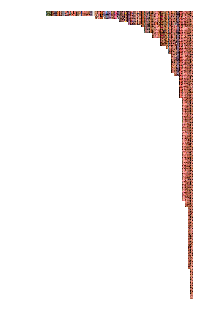

In [38]:
main.main('faces/',sim=0.65,vis=True)

In [ ]:
!tree SAA_clip_key_frames/imagecluster/clusters/

## Similarities

In [ ]:
def find_scenes(vid_path, threshold):
    """Groups shots into scenes"""
    print('Finding shot boundaries...')
    shot_bounds = shot_boundaries(vid_path)
    print('Extracting key frames...')
    key_frames, kf_timestamps = get_key_frames(shot_bounds,vid_path)
    #print(key_frames)
    scene_count = 0
    n_shots = len(key_frames)
    scenes = [0] #What scene is each shot - length = no. of shots [Maps shots to scenes]
    key_shots = [0] #Key shot for each scene [Maps scenes to their key shots]
    print('Classifying shots into scenes...')
    for i in tqdm(range(1, n_shots)): #For each shot
        curr_shot = key_frames[i]
        found = False
        for key_shot in key_shots[-1:-16:-1]: #Iterate through key_shots of last few scenes - param
            if (similarity(key_frames[key_shot],curr_shot) > threshold):
                found = True
                scenes.append(scenes[key_shot]) #Mark the shot as belonging to this scene
                break
        if (found == False): #End of scenes => No matching scene is found
            scene_count += 1 
            scenes.append(scene_count) #This shot belongs to the new scene
            key_shots.append(i) #Mark this shot as key shot of the new scene
    return (scenes, key_shots, scene_count, kf_timestamps)

In [ ]:
output = find_scenes("../../2006-01-02_0000_US_00001057_V11_M2_VHS10_H4_JA.mp4", 0.6)

In [ ]:
ping_telegram('Finding scenes done!')

### Pickling output

In [ ]:
#Pickling data as a binary stream
file = open('dump_binary','wb')
pickle.dump(output, file)
file.close()

In [ ]:
#Loading pickle
infile = open('dump_binary','rb')
pp = pickle.load(infile)